In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json, iter_thresholds
from common.dataloader import load_dataset
from common.sliding import WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm import MultiLSTMEncoder
from torch import nn
%matplotlib inline

In [19]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None
params["inter"] = "MEAN"
params["window_size"] = 32

In [20]:
data_dict = load_dataset("SMD","machine-2-4", use_dim="all")
# data_dict["train"].max(), data_dict["train"].min()

2021-02-22 00:42:42,940 P30001 INFO Loading machine-2-4 of SMD dataset
2021-02-22 00:42:42,942 P30001 INFO 1 files found.


In [21]:
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
data_dict = pp.normalize(data_dict,method="minmax")
window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)
window_dict["train_windows"].shape

2021-02-22 00:42:43,107 P30001 INFO Saving preprocessor into ./checkpoints/20210222-004241/preprocessor.pkl
2021-02-22 00:42:43,108 P30001 INFO Normalizing data
2021-02-22 00:42:43,125 P30001 INFO Generating sliding windows (size 32).
2021-02-22 00:42:43,234 P30001 INFO Train windows #: (4732, 32, 38)
2021-02-22 00:42:43,235 P30001 INFO Test windows #: (23657, 32, 38)


(4732, 32, 38)

In [22]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]

In [23]:
params["nb_steps"] = 30
encoder = MultiLSTMEncoder(**params)

2021-02-22 00:42:43,580 P30001 INFO Compiling finished.


In [24]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-02-22 00:42:44,280 P30001 INFO Start training for 74 batches.
2021-02-22 00:42:44,467 P30001 INFO Epoch: 1, loss: 54.04411
2021-02-22 00:42:44,659 P30001 INFO Epoch: 2, loss: 16.28323
2021-02-22 00:42:44,843 P30001 INFO Epoch: 3, loss: 13.13729
2021-02-22 00:42:45,016 P30001 INFO Epoch: 4, loss: 12.05039
2021-02-22 00:42:45,208 P30001 INFO Epoch: 5, loss: 11.37657
2021-02-22 00:42:45,380 P30001 INFO Epoch: 6, loss: 10.88335
2021-02-22 00:42:45,578 P30001 INFO Epoch: 7, loss: 10.34902
2021-02-22 00:42:45,756 P30001 INFO Epoch: 8, loss: 10.23515
2021-02-22 00:42:45,931 P30001 INFO Epoch: 9, loss: 9.94609
2021-02-22 00:42:46,114 P30001 INFO Epoch: 10, loss: 9.72167
2021-02-22 00:42:46,290 P30001 INFO Epoch: 11, loss: 9.58107
2021-02-22 00:42:46,474 P30001 INFO Epoch: 12, loss: 9.29550
2021-02-22 00:42:46,654 P30001 INFO Epoch: 13, loss: 9.19569
2021-02-22 00:42:46,828 P30001 INFO Epoch: 14, loss: 9.21416
2021-02-22 00:42:47,014 P30001 INFO Epoch: 15, loss: 9.02447
2021-02-22 00:42:47

In [25]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader

loader = test_iterator.loader
encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).squeeze()
real_list = torch.cat(real_list).squeeze()
diff_list = (recst_list - real_list).sigmoid()
recst_list = recst_list.cpu().numpy()
real_list = real_list.cpu().numpy()

score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"])
best_f1, best_theta, best_adjust, best_raw = iter_thresholds(
            score_dict["score"], score_dict["anomaly_label"]
        )
# plt.plot(best_raw, "r")
# plt.plot(best_adjust + 0.1, "b")
# plt.plot(score_dict["anomaly_label"]+0.3, "g")
# plt.plot(score_dict["score"], "g")

2021-02-22 00:42:50,215 P30001 INFO Evaluating


14.357690586270513


2021-02-22 00:42:55,627 P30001 INFO AUC: 0.650, F1: 0.277(0.818), PS: 0.226(0.970), RC:0.358(0.706)


In [26]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)
print(window_dict["test_labels"].shape)
print(real_list.min(), real_list.max(), recst_list.min(), recst_list.max())

(23657, 38)
(23657, 38)
torch.Size([23657, 38])
(23657, 32)
0.0 1.0 -0.00990505 1.2064363


In [27]:
real_list[0:, 9].sum()

0.069814

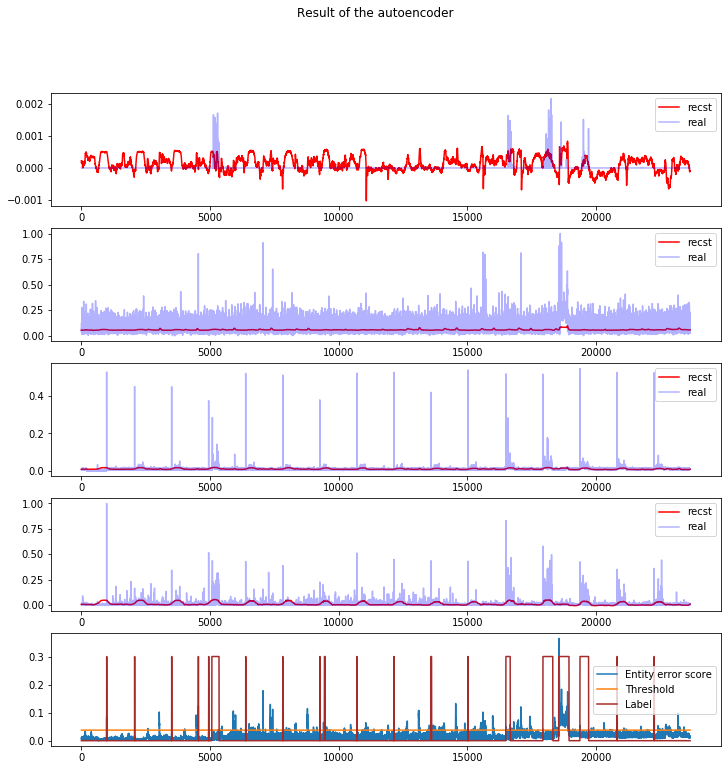

In [28]:
dims = [9,10,13,14]
fig, ax = plt.subplots(nrows=len(dims)+1, sharey=False, figsize=(12,12))
i=0
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
for i in range(len(dims)):
    j = dims[i] 
    ax[i].plot(recst_list[0:, j].reshape(-1), 'r', label='recst', alpha=1)
    ax[i].plot(real_list[0:, j].reshape(-1), 'b', label='real', alpha=0.3)
#     ax[i].plot(diff_list[0:, j].reshape(-1), 'g', label='KPI Error Score')
#     ax[i].plot(window_dict["test_labels"][0:, -1].reshape(-1)*0.2+0.4, 'brown', label='Label')
    ax[i].legend(loc='best')
#     ax[i].set_ylim([0.8,1])
# ax[-1].plot(diff_list[:, [5, 6, 10, 14, 18, 29]].max(axis=-1)[0])
ax[-1].plot((score_dict["score"]-0.5) * 10, label='Entity error score')
ax[-1].plot([(best_theta-0.5)*10] * len(score_dict["score"]), label='Threshold')
ax[-1].plot(window_dict["test_labels"][0:, -1].reshape(-1)*0.3, 'brown', label='Label')
# ax[-1].set_ylim([0.8,1])
# ax[1].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()